<a href="https://colab.research.google.com/github/AugustBirch/02456_RecSys/blob/main/News_Recommendation_Model_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Here we import all libraries needed**



In [ ]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import LayerNormalization, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from sklearn.metrics import roc_auc_score

**Here we connect our program to google disc and load input data from it**

In [ ]:
SIZE = 'demo'

In [1]:
num_heads = 68                  # Number of attention heads in the attention layer
batch_size = 64                 # Number of samples used in each training iteration
epochs_num = 10                 # Number of times the model will iterate over the entire training dataset
initial_learning_rate=0.0001     # Initial value of learning rate (learning rate is dynamically set by the scheduler)
max_history_length = 36         # Maximum length of user history considered by the model
max_articles_in_view = 48       # Maximum number of articles in a user's viewing session (if applicable)
max_in_session_history = 4      # Maximum number of articles in a user's in-session history
popularity_window_hours = 72    # Number of hours to consider for popularity calculation
top_N_popular_articles = 2     # Number of top popular articles to consider
lambda_diversity = 0.0          # Regularization parameter for diversity loss

In [ ]:
def filter_invalid_clicked_articles(df_behaviors):
    """
    Filter rows in df_behaviors where `article_ids_clicked` contains multiple articles.
    """
    # Ensure column exists
    if 'article_ids_clicked' not in df_behaviors.columns:
        raise KeyError("'article_ids_clicked' column not found in df_behaviors.")

    # Count rows before filtering
    total_rows = len(df_behaviors)

    # Filter rows where article_ids_clicked contains only one or no article
    valid_rows = df_behaviors['article_ids_clicked'].apply(
        lambda x: isinstance(x, (list, np.ndarray)) and len(x) <= 1
    )
    df_filtered = df_behaviors[valid_rows].copy()

    # Log the number of rows dropped
    dropped_rows = total_rows - len(df_filtered)
    print(f"Filtered out {dropped_rows} rows with invalid `article_ids_clicked` values.")

    return df_filtered

In [ ]:
# LOADING THE DATA

# Get the directory of the current script and move one level up
BASE_DIR = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__)))),'data')
TRAIN_DIR = os.path.join(BASE_DIR, SIZE, 'train')
VALID_DIR = os.path.join(BASE_DIR, SIZE, 'validation')
ARTICLE_DIR = os.path.join(BASE_DIR, SIZE)

TEST_ARTICLES_DIR = os.path.join(BASE_DIR, 'ebnerd_testset')
TEST_DIR = os.path.join(BASE_DIR, 'ebnerd_testset', 'test')

EMBEDDING_DIR = os.path.join(BASE_DIR, 'artifacts', 'Ekstra_Bladet_word2vec')
# /work3/s204129/DL2024/data/artifacts/Ekstra_Bladet_word2vec/document_vector.parquet

print("Starting loading data...")

# Load the datasets
df_train_history = pd.read_parquet(os.path.join(TRAIN_DIR, 'history.parquet'))
df_train_behaviors = pd.read_parquet(os.path.join(TRAIN_DIR, 'behaviors.parquet'))
df_train_articles = pd.read_parquet(os.path.join(ARTICLE_DIR, 'articles.parquet'))

df_valid_history = pd.read_parquet(os.path.join(VALID_DIR, 'history.parquet'))
df_valid_behaviors = pd.read_parquet(os.path.join(VALID_DIR, 'behaviors.parquet'))
df_valid_articles = pd.read_parquet(os.path.join(ARTICLE_DIR, 'articles.parquet'))

df_test_history = pd.read_parquet(os.path.join(TEST_DIR, 'history.parquet'))
df_test_behaviors = pd.read_parquet(os.path.join(TEST_DIR, 'behaviors.parquet'))
df_test_articles = pd.read_parquet(os.path.join(TEST_ARTICLES_DIR, 'articles.parquet'))

# Ensure consistent data types for merging in train dataset
df_train_behaviors['article_id'] = df_train_behaviors['article_id'].fillna('-1').astype(str)
df_train_articles['article_id'] = df_train_articles['article_id'].astype(str)

# Ensure consistent data types for merging in validation dataset
df_valid_behaviors['article_id'] = df_valid_behaviors['article_id'].fillna('-1').astype(str)
df_valid_articles['article_id'] = df_valid_articles['article_id'].astype(str)

# Ensure consistent data types for merging in test dataset
df_test_articles['article_id'] = df_test_articles['article_id'].astype(str)

# Filter invalid rows from behaviors dataset
df_train_behaviors = filter_invalid_clicked_articles(df_train_behaviors)
df_valid_behaviors = filter_invalid_clicked_articles(df_valid_behaviors)

print("Data loaded successfully")


In [2]:
# EMBEDDINGS OF ARTICLES
print("Loading embeddings...")
# Import the embedding fle provided by the competition organizers
embedding_df = pd.read_parquet(EMBEDDING_DIR)

# Check the embedding vectors dimension
embedding_dim = len(embedding_df['document_vector'].iloc[0])

# Mapping article_id -> embedding index
article_to_index = {article_id: idx for idx, article_id in enumerate(embedding_df['article_id'])}

# Initialisation of embedding matrix
num_articles = len(article_to_index)
embedding_matrix = np.zeros((num_articles, embedding_dim))

# Populate the embedding matrix
for idx, row in embedding_df.iterrows():
    embedding_matrix[article_to_index[row['article_id']]] = row['document_vector'][:embedding_dim]
print("Embeddings loaded successfully")


NameError: name 'pd' is not defined

**Here we define functions which are used to pre-process the input data**

In [ ]:
# THIS FUNCTION CREATES A LIST OF IDs OF ARTICLES WHICH WERE VIEWED IN EACH SESSION (USED FOR INSESSION ENCODER)

def build_in_session_histories(df_behaviors):
    # Sort by user_id, session_id, and impression_time
    df_behaviors = df_behaviors.sort_values(['user_id', 'session_id', 'impression_time'])

    # Initialize a dictionary to store in-session histories
    in_session_histories = {}

    # Group by session
    grouped = df_behaviors.groupby(['user_id', 'session_id'])

    # Iterate over each session
    for (user_id, session_id), group in grouped:
        viewed_articles = []
        for idx, row in group.iterrows():

            # Store the current viewed articles
            in_session_histories[idx] = list(viewed_articles)

            # Update the viewed_articles list with the current article
            article_id = row['article_id']
            if article_id is not None:
                viewed_articles.append(article_id)

    return in_session_histories

In [ ]:
# THIS FUNCTION ADDS THE EMBEDDINGS OF POPULAR ARTICLES TO EACH ROW IN BEHAVIOURS (USED FOR POPULARITY ENCODER)

def compute_popularity_features(df_behaviors, popularity_window_hours, top_n=10):
    """
    Adds a 'popularity_articles' column to df_behaviors, which lists the top N articles
    popular in the last 'popularity_window_hours' before each impression.
    """
    # Convert 'impression_time' to datetime
    df_behaviors['impression_time'] = pd.to_datetime(df_behaviors['impression_time'])

    # Create a DataFrame 'df_views' containing each viewed article with the corresponding time
    df_views = df_behaviors[['impression_time', 'article_id']].dropna(subset=['article_id'])

    # Set 'impression_time' as the index and sort it
    df_views.set_index('impression_time', inplace=True)
    df_views.sort_index(inplace=True)

    # Initialize a cache dictionary to store popularity for each time period
    popularity_cache = {}

    # Time window in Timedelta
    time_window = pd.Timedelta(hours=popularity_window_hours)

    # Iterate through unique impression times
    impression_times = df_behaviors['impression_time'].unique()

    for time in impression_times:
        if time in popularity_cache:
            continue
        # Define the time window
        start_time = time - time_window
        # Ensure that start_time and time are Timestamps
        start_time = pd.to_datetime(start_time)
        time = pd.to_datetime(time)
        # Filter views in the time window
        views_in_window = df_views.loc[start_time:time]
        # Count article views
        article_counts = views_in_window['article_id'].value_counts()
        # Get the top N most popular articles
        popular_articles = article_counts.head(top_n).index.tolist()
        # Store results in the cache
        popularity_cache[time] = popular_articles

    # Map popularity to df_behaviors
    df_behaviors['popularity_articles'] = df_behaviors['impression_time'].map(popularity_cache)

    # Replace NaN with an empty list if there are no popular articles
    df_behaviors['popularity_articles'] = df_behaviors['popularity_articles'].apply(lambda x: x if isinstance(x, list) else [])

    return df_behaviors

In [ ]:
# THIS FUNCTION GATHERS THE ARTICLES WHICH HAVE BEEN READ BY THE USER IN THE PAST (USED FOR USER ENCODER)

# Function to transform the history of the user into tensor containing the articles embeddings
def process_user_history(df_history, article_to_index, embedding_matrix, max_history_length):

    # Initialize a list to store padded embeddings
    article_embeddings = []

    for article_ids in df_history['article_id_fixed']:
        # Collect embeddings for valid article IDs
        embeddings = [embedding_matrix[article_to_index[article_id]]
                      for article_id in article_ids if article_id in article_to_index]

        # Pad or truncate to the fixed history length
        if len(embeddings) > max_history_length:
            embeddings = embeddings[:max_history_length]
        elif len(embeddings) < max_history_length:
            embeddings += [np.zeros(embedding_matrix.shape[1])] * (max_history_length - len(embeddings))

        article_embeddings.append(embeddings)

    # Convert to a NumPy array and ensure correct dtype
    padded_array = np.array(article_embeddings, dtype=np.float32)

    # Map user to index
    user_id_to_index = {user_id: idx for idx, user_id in enumerate(df_history['user_id'].unique())}

    return tf.convert_to_tensor(padded_array), user_id_to_index

In [ ]:
# THIS FUNCTIONS ARE USED TO GENERATE FINAL VERSION OF BEHAVIOURS WHICH INCLUDES EMBEDDINGS OF POPULAR ARTICLES AND ARTICLES READ IN THIS SESSION

# Helper function to pad / truncate the list
def pad_or_truncate_list(lst, target_length, padding_value):
    lst = list(lst)
    if len(lst) > target_length:
        return lst[:target_length]
    else:
        return lst + [padding_value] * (target_length - len(lst))

# Function that creates the labeled sessions
def generate_session_labels(df_behaviors, article_to_index, embedding_matrix, max_articles_in_view=10, max_in_session_history=5, max_popularity_articles=10):
    session_data = []

    for _, row in df_behaviors.iterrows():
        user_id = row['user_id']
        impression_id = row['impression_id']
        articles_in_view = np.array(row['article_ids_inview'])
        articles_clicked = set(row['article_ids_clicked']) if row['article_ids_clicked'] is not None else set()
        in_session_history = row['in_session_history']

        # Generate embeddings for in-session history
        in_session_embeddings = [
            embedding_matrix[article_to_index.get(article_id, 0)]
            for article_id in in_session_history
        ]

        # Pad or truncate to max_in_session_history
        in_session_embeddings = pad_or_truncate_list(in_session_embeddings, max_in_session_history, np.zeros(embedding_matrix.shape[1]))

        # Popularity articles embeddings
        popularity_articles = row['popularity_articles']
        popularity_embeddings = [
            embedding_matrix[article_to_index.get(article_id, 0)]
            for article_id in popularity_articles
        ]
        popularity_embeddings = pad_or_truncate_list(popularity_embeddings, max_popularity_articles, np.zeros(embedding_matrix.shape[1]))

        # Existing code for article embeddings and labels
        embeddings = [
            embedding_matrix[article_to_index.get(article_id, 0)]
            for article_id in articles_in_view
        ]
        embeddings = pad_or_truncate_list(embeddings, max_articles_in_view, np.zeros(embedding_matrix.shape[1]))

        labels = np.isin(articles_in_view, list(articles_clicked)).astype(int)
        labels = pad_or_truncate_list(labels, max_articles_in_view, 0)

        session_data.append({
            'user_id': user_id,
            'impression_id': impression_id,
            'article_embeddings': embeddings,
            'in_session_embeddings': in_session_embeddings,
            'popularity_embeddings': popularity_embeddings,
            'labels': labels,
            # Include other features as needed
        })

    return pd.DataFrame(session_data)

# Function that creates the labeled sessions during the testinf phase
def prepare_test_sessions(df_behaviors, article_to_index, embedding_matrix, max_articles_in_view=10, max_in_session_history=5, max_popularity_articles=10):
    session_data = []

    for _, row in df_behaviors.iterrows():
        user_id = row['user_id']
        impression_id = row['impression_id']
        articles_in_view = np.array(row['article_ids_inview'])

        # In-session history embeddings
        in_session_history = row.get('in_session_history', [])
        in_session_embeddings = [
            embedding_matrix[article_to_index.get(article_id, 0)]
            for article_id in in_session_history
        ]
        in_session_embeddings = pad_or_truncate_list(in_session_embeddings, max_in_session_history, np.zeros(embedding_matrix.shape[1]))

        # Popularity articles embeddings
        popularity_articles = row.get('popularity_articles', [])
        popularity_embeddings = [
            embedding_matrix[article_to_index.get(article_id, 0)]
            for article_id in popularity_articles
        ]
        popularity_embeddings = pad_or_truncate_list(popularity_embeddings, max_popularity_articles, np.zeros(embedding_matrix.shape[1]))

        # Article embeddings
        embeddings = [
            embedding_matrix[article_to_index.get(article_id, 0)]
            for article_id in articles_in_view
        ]
        embeddings = pad_or_truncate_list(embeddings, max_articles_in_view, np.zeros(embedding_matrix.shape[1]))

        session_data.append({
            'user_id': user_id,
            'impression_id': impression_id,
            'article_embeddings': embeddings,
            'in_session_embeddings': in_session_embeddings,
            'popularity_embeddings': popularity_embeddings,
            # No labels since we don't have 'article_ids_clicked'
        })

    return pd.DataFrame(session_data)

In [ ]:
# FUNCTIONS USED TO CREATE FINAL DATASET INCLUDING THE EMBEDDINGS OF ARTICLES READ BY THE USER IN HISTORY (USER REPRESENTATION), IN THE CURRENT SESSION (INSESSION REPRESENTATION) AND POPULAR ARTICLES (POPULARITY REPRESENTATION)

# Function used during the training/valuation phase
def create_tf_dataset(df_labeled_sessions, user_id_to_index, batch_size):
    user_indices = df_labeled_sessions['user_id'].map(user_id_to_index).fillna(0).astype(int).to_numpy()
    article_embeddings = np.stack(df_labeled_sessions['article_embeddings'].to_numpy())
    in_session_embeddings = np.stack(df_labeled_sessions['in_session_embeddings'].to_numpy())
    popularity_embeddings = np.stack(df_labeled_sessions['popularity_embeddings'].to_numpy())
    labels = np.stack(df_labeled_sessions['labels'].to_numpy())

    dataset = tf.data.Dataset.from_tensor_slices(
        ((user_indices, article_embeddings, in_session_embeddings, popularity_embeddings), labels)
    ).batch(batch_size)

    return dataset

# The same function but used for testing/predictions
def create_tf_dataset_for_prediction(df_sessions, user_id_to_index, batch_size):
    user_indices = df_sessions['user_id'].map(user_id_to_index).astype(int).to_numpy()
    article_embeddings = np.stack(df_sessions['article_embeddings'].to_numpy())
    in_session_embeddings = np.stack(df_sessions['in_session_embeddings'].to_numpy())
    popularity_embeddings = np.stack(df_sessions['popularity_embeddings'].to_numpy())

    dataset = tf.data.Dataset.from_tensor_slices((
        (user_indices, article_embeddings, in_session_embeddings, popularity_embeddings)
    ))

    return dataset.batch(batch_size)

**Here we define the model class and its sub-classes**

In [ ]:
# CLASSES OF ALL SUB-MODELS

class UserEncoder(Model):
    def __init__(self, embedding_dim, num_heads, dropout_rate=0.2, **kwargs):
        super(UserEncoder, self).__init__(**kwargs)

        # Self-attention layer
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.layer_norm1 = layers.LayerNormalization()
        self.dropout1 = layers.Dropout(dropout_rate)

        # Additive attention layer
        self.additive_attention_dense = layers.Dense(embedding_dim, activation='tanh')
        self.layer_norm2 = layers.LayerNormalization()
        self.dropout2 = layers.Dropout(dropout_rate)

        # Extra dense layer
        self.attention_score_dense = layers.Dense(1)
        self.softmax = layers.Softmax(axis=1)

    def call(self, inputs):

        # Self-attention layer
        attention_output = self.multi_head_attention(inputs, inputs)
        attention_output = self.layer_norm1(attention_output)
        attention_output = self.dropout1(attention_output)

        # Additive attention layer
        additive_attention_output = self.additive_attention_dense(attention_output)
        additive_attention_output = self.layer_norm2(additive_attention_output)
        additive_attention_output = self.dropout2(additive_attention_output)

        # Dense layer
        attention_scores = self.attention_score_dense(additive_attention_output)
        attention_weights = self.softmax(attention_scores)

        weighted_output = tf.reduce_sum(attention_output * attention_weights, axis=1)
        return weighted_output

class InSessionEncoder(Model):
    def __init__(self, embedding_dim, num_heads, **kwargs):
        super(InSessionEncoder, self).__init__(**kwargs)
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.layer_norm = layers.LayerNormalization()
        self.dropout = layers.Dropout(0.2)
        self.output_layer = layers.Dense(embedding_dim)

    def call(self, inputs):
        attention_output = self.multi_head_attention(inputs, inputs)
        attention_output = self.layer_norm(attention_output)
        attention_output = self.dropout(attention_output)
        # Aggregate the outputs
        in_session_representation = tf.reduce_mean(attention_output, axis=1)
        in_session_representation = self.output_layer(in_session_representation)
        return in_session_representation

class PopularityEncoder(Model):
    def __init__(self, embedding_dim, num_heads, **kwargs):
        super(PopularityEncoder, self).__init__(**kwargs)
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.layer_norm = layers.LayerNormalization()
        self.dropout = layers.Dropout(0.2)
        self.output_layer = layers.Dense(embedding_dim)

    def call(self, inputs):
        # inputs: tensor with dimensions: (batch_size, max_popularity_articles, embedding_dim)
        attention_output = self.multi_head_attention(inputs, inputs)
        attention_output = self.layer_norm(attention_output)
        attention_output = self.dropout(attention_output)
        # Aggregation of outputs
        popularity_representation = tf.reduce_mean(attention_output, axis=1)
        popularity_representation = self.output_layer(popularity_representation)
        return popularity_representation

class ClickPredictor(Model):
    def __init__(self, input_dim, **kwargs):
        super(ClickPredictor, self).__init__(**kwargs)
        self.dense1 = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.dropout1 = layers.Dropout(0.2)
        self.dense2 = layers.Dense(128, activation='relu')
        self.dropout2 = layers.Dropout(0.2)
        self.dense3 = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        click_probability = self.dense3(x)
        return click_probability

In [ ]:
# NEWS RECOMMENDATION MODEL - CLASS USED TO DEFINE THE MAIN MODEL (BACKBONE OF THE ENTIRE MODEL) IN WHICH WE RUN ALL ABOVE SUB-MODELS AND ADD SOME EXTRA LAYERS/FUNCTIONALITIES

class NewsRecommendationModel(Model):
    def __init__(self, user_histories_tensor, embedding_dim, num_heads, **kwargs):
        super(NewsRecommendationModel, self).__init__(**kwargs)
        self.user_histories_tensor = user_histories_tensor

        # Sub-models
        self.user_encoder = UserEncoder(embedding_dim=embedding_dim, num_heads=num_heads)
        self.in_session_encoder = InSessionEncoder(embedding_dim=embedding_dim, num_heads=num_heads)
        self.popularity_encoder = PopularityEncoder(embedding_dim=embedding_dim, num_heads=num_heads)
        self.click_predictor = ClickPredictor(input_dim=embedding_dim)

        # Self-attention layer
        self.self_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(0.2)

        # Dense layer for combined representation projection
        self.combined_representation_projection = layers.Dense(embedding_dim, activation='relu')

    def call(self, inputs):
        user_indices, article_embeddings, in_session_embeddings, popularity_embeddings = inputs

        # User representation
        user_histories = tf.gather(self.user_histories_tensor, user_indices)
        user_representation = self.user_encoder(user_histories)

        # In-session representation
        in_session_representation = self.in_session_encoder(in_session_embeddings)

        # Popularity representation
        popularity_representation = self.popularity_encoder(popularity_embeddings)

        # Combining user representations
        combined_representation = tf.concat([user_representation, in_session_representation, popularity_representation], axis=-1)  # Shape: (batch_size, combined_dim)

        # Projection to embedding_dim
        combined_representation = self.combined_representation_projection(combined_representation)  # Shape: (batch_size, embedding_dim)

        # Preparing data for attention
        batch_size = tf.shape(article_embeddings)[0]
        num_articles = tf.shape(article_embeddings)[1]

        # Expanding dimensions and concatenation
        user_representation_expanded = tf.expand_dims(combined_representation, axis=1)  # Shape: (batch_size, 1, embedding_dim)
        sequence = tf.concat([user_representation_expanded, article_embeddings], axis=1)  # Shape: (batch_size, num_articles + 1, embedding_dim)

        # Applying self-attention
        attention_output = self.self_attention(sequence, sequence)
        attention_output = self.dropout(attention_output)
        attention_output = self.layer_norm(sequence + attention_output)

        # Extracting article representations after attention (skipping the first element, which is the user representation)
        article_attention_output = attention_output[:, 1:, :]  # Shape: (batch_size, num_articles, embedding_dim)

        # Flattening and click prediction for each article
        article_flat = tf.reshape(article_attention_output, [-1, embedding_dim])  # Shape: (batch_size * num_articles, embedding_dim)
        click_probabilities_flat = self.click_predictor(article_flat)  # Shape: (batch_size * num_articles, 1)
        click_probabilities = tf.reshape(click_probabilities_flat, [batch_size, num_articles])  # Shape: (batch_size, num_articles)

        return click_probabilities

**Here we define all the hyperparameters used in the model**

In [ ]:
# DEFINE ALL THE HYPERPARAMETERS

num_heads = 16                  # Number of attention heads in the attention layer
batch_size = 64                 # Number of samples used in each training iteration
epochs_num = 16                 # Number of times the model will iterate over the entire training dataset
initial_learning_rate=0.001     # Initial value of learning rate (learning rate is dynamically set by the scheduler)
max_history_length = 32         # Maximum length of user history considered by the model
max_articles_in_view = 10       # Maximum number of articles in a user's viewing session (if applicable)
max_in_session_history = 5      # Maximum number of articles in a user's in-session history
popularity_window_hours = 48    # Number of hours to consider for popularity calculation
top_N_popular_articles = 10     # Number of top popular articles to consider

**Here we pass the input data through the predefined functions (input data pre-processing)**

In [ ]:
# HERE WE CALL ALL THE FUNCTIONS USED TO PREPROCESS THE DATA

def prepare_data(df_history, df_behaviors, df_articles, article_to_index, embedding_matrix, max_history_length, popularity_window_hours, top_N_popular_articles, max_articles_in_view, max_in_session_history, is_training=True):

    # Compute and add in-session history
    in_session_histories = build_in_session_histories(df_behaviors)
    df_behaviors['in_session_history'] = df_behaviors.index.map(in_session_histories)

    # Compute popularity features
    df_behaviors = compute_popularity_features(df_behaviors, popularity_window_hours, top_N_popular_articles)

    # Prepare user histories
    user_histories_tensor, user_id_to_index = process_user_history(df_history, article_to_index, embedding_matrix, max_history_length)

    # Generate session labels
    df_labeled_sessions = generate_session_labels(df_behaviors, article_to_index, embedding_matrix, max_articles_in_view, max_in_session_history, top_N_popular_articles)

    # Create dataset
    dataset = create_tf_dataset(df_labeled_sessions, user_id_to_index, batch_size)

    return dataset, user_histories_tensor, user_id_to_index

# Prepare datasets
train_dataset, train_user_histories_tensor, user_id_to_index = prepare_data(df_train_history, df_train_behaviors, df_train_articles, article_to_index, embedding_matrix, max_history_length, popularity_window_hours, top_N_popular_articles, max_articles_in_view, max_in_session_history, is_training=True)
validation_dataset, _, _ = prepare_data(df_valid_history, df_valid_behaviors, df_valid_articles, article_to_index, embedding_matrix, max_history_length, popularity_window_hours, top_N_popular_articles, max_articles_in_view, max_in_session_history, is_training=False)

**Here we train and test the model**

In [ ]:
# HERE WE INITIALIZE THE MODEL AND USE THE PREPROCESSED DATA TO TRAIN IT

# Create a model instance
model = NewsRecommendationModel(
                                user_histories_tensor=train_user_histories_tensor,
                                embedding_dim=embedding_dim,
                                num_heads=num_heads
                              )

# Define the loss function
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Define the scheduler (to dynamically set the optimal learning rate)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9)

# Create optimizer using above scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Define the callback (reduces the learning rate when the validation loss stops to decrease)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

# Compile the model
model.compile(optimizer=optimizer,  # Use the optimizer instance
              loss=loss_fn,
              metrics=[tf.keras.metrics.AUC(name="auc")])

# Train the model
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs_num,
    callbacks=[reduce_lr]
)

Epoch 1/16
387/387 ━━━━━━━━━━━━━━━━━━━━ 62s 107ms/step - auc: 0.6616 - loss: 0.4763 - val_auc: 0.7279 - val_loss: 0.3020 - learning_rate: 9.9593e-04
Epoch 2/16
387/387 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - auc: 0.7405 - loss: 0.2881 - val_auc: 0.7266 - val_loss: 0.2699 - learning_rate: 9.9188e-04
Epoch 3/16
387/387 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - auc: 0.7455 - loss: 0.2640 - val_auc: 0.7266 - val_loss: 0.2662 - learning_rate: 9.8784e-04
Epoch 4/16
387/387 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - auc: 0.7484 - loss: 0.2589 - val_auc: 0.7238 - val_loss: 0.2679 - learning_rate: 9.8382e-04
Epoch 5/16
387/387 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - auc: 0.7511 - loss: 0.2571 - val_auc: 0.7262 - val_loss: 0.2654 - learning_rate: 9.7982e-04
Epoch 6/16
387/387 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - auc: 0.7535 - loss: 0.2563 - val_auc: 0.7267 - val_loss: 0.2637 - learning_rate: 9.7583e-04
Epoch 7/16
387/387 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - auc: 0.7561 - loss: 0.2555 - val_auc: 0.7253 - val_loss

In [ ]:
# HERE WE PASS THE VALIDATION DATA THROUGH THE MODEL TO MAKE PREDICTIONS AND COMPUTE THE VALIDATION AUC

# Make predictions
predictions = model.predict(validation_dataset)
labels = np.concatenate([y for x, y in validation_dataset], axis=0)

# Flatten arrays
predictions_flat = predictions.flatten()
labels_flat = labels.flatten()

# Compute AUC
auc_score = roc_auc_score(labels_flat, predictions_flat)
print(f"AUC on validation data: {auc_score:.4f}")


397/397 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step
AUC on validation data: 0.7231


In [ ]:
# HERE WE PREPROCESS THE TEST DATA (THEY DO NOT INCLUDE THE COLUMN "article_ids_clicked" SO WE HAVE TO DO IT SEPARATELY)

def prepare_test_data(df_history, df_behaviors, df_articles, article_to_index, embedding_matrix, max_history_length, popularity_window_hours, top_N_popular_articles, max_articles_in_view, max_in_session_history, is_training=False):

    # Compute and add in-session history
    in_session_histories = build_in_session_histories(df_behaviors)
    df_behaviors['in_session_history'] = df_behaviors.index.map(in_session_histories)

    # Compute popularity features
    df_behaviors = compute_popularity_features(df_behaviors, popularity_window_hours, top_N_popular_articles)

    # Prepare user histories
    user_histories_tensor, user_id_to_index = process_user_history(df_history, article_to_index, embedding_matrix, max_history_length)

    # Prepare test sessions without labels
    df_sessions = prepare_test_sessions(df_behaviors, article_to_index, embedding_matrix, max_articles_in_view, max_in_session_history, top_N_popular_articles)

    # Create dataset without labels
    dataset = create_tf_dataset_for_prediction(df_sessions, user_id_to_index, batch_size=32)

    return dataset, user_histories_tensor, user_id_to_index, df_sessions

test_dataset, test_user_histories_tensor, user_id_to_index, df_test_sessions = prepare_test_data(df_test_history, df_test_behaviors, df_test_articles, article_to_index, embedding_matrix, max_history_length, popularity_window_hours, top_N_popular_articles, max_articles_in_view, max_in_session_history, is_training=False)

In [ ]:
# HERE WE MAKE PREDICTIONS USING THE TEST INPUT DATA

# Switch the user histories tensor to those from test data (not sure if we need to do that)
#model.user_histories_tensor = test_user_histories_tensor

# Extract user indices
user_indices = df_test_sessions['user_id'].map(user_id_to_index).astype(int).to_numpy()

# Extract embeddings
article_embeddings = np.stack(df_test_sessions['article_embeddings'].to_numpy())
in_session_embeddings = np.stack(df_test_sessions['in_session_embeddings'].to_numpy())
popularity_embeddings = np.stack(df_test_sessions['popularity_embeddings'].to_numpy())

# Create an inputs list
inputs = [user_indices, article_embeddings, in_session_embeddings, popularity_embeddings]

# Make test predictions
test_predictions = model.predict(inputs)

793/793 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step


# Ethical aspects

In [ ]:
# Extract the column article_ids_inview from df_test_behaviors
candidate_articles = df_valid_behaviors['article_ids_inview'].tolist()

# Convert the IDs to strings (only once necessary)
candidate_articles = [[str(article) for article in articles] for articles in candidate_articles]

# Convert all article_id values to strings in the embedding dataframe (if necessary)
embedding_df['article_id'] = embedding_df['article_id'].astype(str)

# Flatten the list of lists to create a set of unique candidate article IDs
candidate_articles_flat = set(article for sublist in candidate_articles for article in sublist)
embedding_articles = set(embedding_df['article_id'])

# Common articles
common_articles = candidate_articles_flat.intersection(embedding_articles)
print(f"Number of common articles: {len(common_articles)}")

# Missing articles
missing_articles = candidate_articles_flat.difference(embedding_articles)
print(f"Number of missing articles: {len(missing_articles)}")


Number of common articles: 2738
Number of missing articles: 0


In [ ]:
# Extract the Top-N recommendations (e.g., Top-5)
top_n = 10
recommendations = [np.argsort(-pred)[:top_n] for pred in predictions]

# Convert indices from recommendations_test to article IDs
article_id_recommendations = [
    [candidate_articles[user_idx][idx] for idx in rec_list if idx < len(candidate_articles[user_idx])]
    for user_idx, rec_list in enumerate(recommendations)
]

# Convert article_id from strings to integers
article_id_recommendations = [
    [int(article) for article in rec_list]
    for rec_list in article_id_recommendations
]

# Filter: Keep only article_id values that have embeddings
article_id_recommendations = [
    [article for article in rec_list if article in article_to_index]
    for rec_list in article_id_recommendations
]

# Convert article_id values to embedding indices
mapped_recommendations = [
    [article_to_index[article] for article in rec_list if article in article_to_index]
    for rec_list in article_id_recommendations
]

# Retrieve embeddings for the recommended lists
recommended_embeddings = [
    [embedding_matrix[idx] for idx in rec_list]
    for rec_list in mapped_recommendations
]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_diversity_from_embeddings(recommended_embeddings):
    """
    Calculates the average Diversity Score for the recommended embedding lists.

    Args:
        recommended_embeddings (list of list): Embeddings for the recommendation lists of each user.

    Returns:
        float: Average Diversity Score for all lists.
    """
    diversities = []
    for rec_list in recommended_embeddings:
        if len(rec_list) > 1:  # If the list contains at least 2 articles
            similarity_matrix = cosine_similarity(rec_list)
            # Diversity: 1 - average similarity
            pairwise_diversity = 1 - similarity_matrix[np.triu_indices(len(rec_list), k=1)].mean()
            diversities.append(pairwise_diversity)
        else:
            diversities.append(0)  # If there's only 1 article, diversity = 0

    # Average diversity score
    return diversities
diversities = calculate_diversity_from_embeddings(recommended_embeddings)
# Call the function with the recommended embeddings
diversity_score = np.mean(calculate_diversity_from_embeddings(recommended_embeddings))
print(f"Diversity Score: {diversity_score:.4f}")


Diversity Score: 0.1857


Diversity measures how different the articles in each user's ecommendation list are from one another.

A Diversity Score of 0.1851 indicates that the articles within each recommendation list are not very diverse. This means that the system tends to recommend articles that are similar in content or topic for each user.

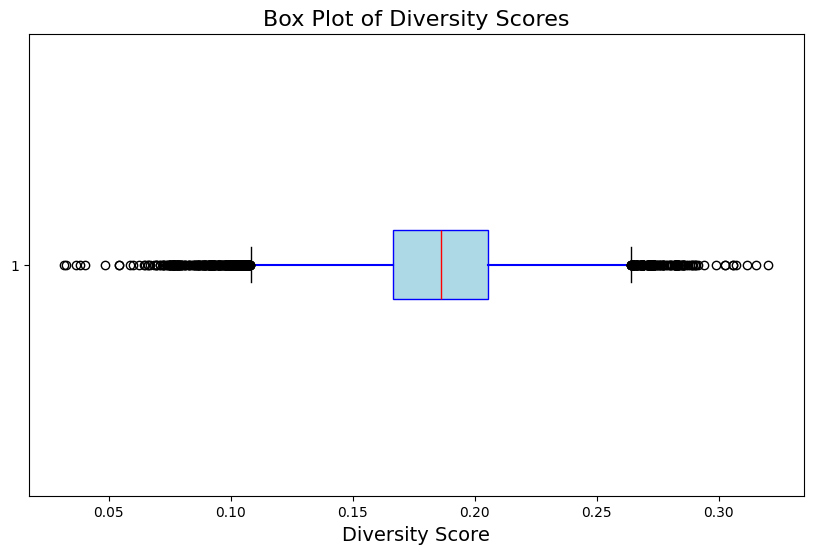

In [ ]:
import matplotlib.pyplot as plt

def plot_diversity_boxplot(diversities):
    plt.figure(figsize=(10, 6))
    plt.boxplot(diversities, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'),
                whiskerprops=dict(color='blue', linewidth=1.5), medianprops=dict(color='red'))
    plt.title('Box Plot of Diversity Scores', fontsize=16)
    plt.xlabel('Diversity Score', fontsize=14)
    plt.show()

# Example usage
# diversities = [0.1715, 0.432, 0.245, 0.876, 0.543, 0.332]  # Replace with your actual diversity scores
plot_diversity_boxplot(diversities)


## Using Diversity into loss

This code defines and trains the model to predict binary labels, incorporating a new objective: the diversity of predictions, alongside accuracy. It uses a custom loss function that combines the usual loss for binary classification (BinaryCrossentropy) with an additional loss function for measuring the diversity of the model's outputs. The diversity is calculated based on the predictions (embeddings) generated by the model during each training epoch. Here are the key steps in this process:

Diversity Calculation:

During training, the model generates predictions (embeddings) for the data.
The diversity_loss function calculates the similarity of these predictions through a self dot product, creating a similarity matrix.
From this matrix, calculating the average similarity (excluding the diagonal representing the similarity of an item with itself) provides the basis for calculating diversity, which is 1 minus the average similarity.
Incorporation into the Loss Function:

The final loss function combines the standard classification loss (e.g., BinaryCrossentropy) with diversity. This is achieved by adding the diversity value, scaled by a weighting factor (lambda_diversity), to the base loss.
Adding the diversity term treats high similarity values as undesirable, encouraging the model to produce more distinct and diverse predictions.
Training:

As the model is trained, TensorFlow automatically adjusts the model's weights to minimize this combined loss, balancing the need for high accuracy and high diversity in predictions.
Thus, diversity is not just a metric for evaluation but becomes a central part of how the model learns and adapts, seeking a good compromise between accuracy and diversity in its predictions.

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy

def diversity_loss(embeddings, lambda_diversity=0.1):
    similarity_matrix = tf.matmul(embeddings, embeddings, transpose_b=True)
    upper_triangle = tf.linalg.band_part(similarity_matrix, 0, -1)
    num_elements = tf.cast(tf.shape(upper_triangle)[0], tf.float32)  # Convert to float32
    average_similarity = tf.reduce_mean(upper_triangle) - tf.linalg.trace(upper_triangle) / num_elements
    diversity = 1 - average_similarity
    return lambda_diversity * diversity


class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, lambda_diversity=0.1, name="custom_loss"):
        super(CustomLoss, self).__init__(name=name)
        self.lambda_diversity = lambda_diversity
        self.base_loss = BinaryCrossentropy()

    def call(self, y_true, y_pred):
        # Base loss
        base_loss_value = self.base_loss(y_true, y_pred)
        # Add diversity loss
        diversity_value = diversity_loss(y_pred, self.lambda_diversity)
        return base_loss_value + diversity_value

# In compile of model, use CustomLoss
model.compile(optimizer=optimizer,
              loss=CustomLoss(lambda_diversity=0.1),
              metrics=[tf.keras.metrics.AUC(name="auc")])


In [ ]:
# Train the model
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs_num,
    callbacks=[reduce_lr]
)


Epoch 1/16
387/387 ━━━━━━━━━━━━━━━━━━━━ 54s 109ms/step - auc: 0.7710 - loss: 0.3584 - val_auc: 0.7211 - val_loss: 0.3728 - learning_rate: 9.3303e-04
Epoch 2/16
387/387 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - auc: 0.7729 - loss: 0.3578 - val_auc: 0.7220 - val_loss: 0.3740 - learning_rate: 9.2923e-04
Epoch 3/16
387/387 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - auc: 0.7744 - loss: 0.3575 - val_auc: 0.7224 - val_loss: 0.3724 - learning_rate: 9.2545e-04
Epoch 4/16
387/387 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - auc: 0.7751 - loss: 0.3572 - val_auc: 0.7233 - val_loss: 0.3713 - learning_rate: 9.2169e-04
Epoch 5/16
387/387 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - auc: 0.7767 - loss: 0.3568 - val_auc: 0.7195 - val_loss: 0.3735 - learning_rate: 9.1794e-04
Epoch 6/16
387/387 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - auc: 0.7767 - loss: 0.3572 - val_auc: 0.7181 - val_loss: 0.3750 - learning_rate: 9.1420e-04
Epoch 7/16
387/387 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - auc: 0.7794 - loss: 0.3561 - val_auc: 0.7180 - val_loss

## Serendipity

In [ ]:
predictions = model.predict(validation_dataset)
labels = np.concatenate([y for x, y in validation_dataset], axis=0)

# Flatten arrays
predictions_flat = predictions.flatten()
labels_flat = labels.flatten()

# Compute AUC
auc_score = roc_auc_score(labels_flat, predictions_flat)
print(f"AUC on test data: {auc_score:.4f}")

397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
AUC on test data: 0.7121


In [ ]:
from collections import Counter

clicked_articles_valid = df_valid_behaviors['article_ids_clicked'].tolist()

# Ensure that IDs are strings (to match other data formats)
clicked_articles_valid = [[str(article) for article in articles] for articles in clicked_articles_valid]

# Count the frequency of articles in the training set
article_counts = Counter(df_train_behaviors['article_id'])

# Extract the Top-K most popular articles (e.g., Top-10)
baseline_articles = [article for article, _ in article_counts.most_common(10)]

# Ensure that IDs are strings
baseline_articles = [str(article) for article in baseline_articles]

# Convert clicked articles to integers
clicked_articles_valid = [[int(article) for article in articles] for articles in clicked_articles_valid]


In [ ]:
def calculate_serendipity(recommendations, clicked_articles, baseline_articles):
    """
    Calculate the Serendipity Score for recommendations.

    Args:
        recommendations (list of list): Lists of recommended article IDs for each user.
        clicked_articles (list of list): Lists of article IDs clicked by each user.
        baseline_articles (list): List of popular article IDs used as a baseline.

    Returns:
        float: Average Serendipity Score across all users.
    """
    serendipities = []
    for rec_list, clicked in zip(recommendations, clicked_articles):
        # Unexpected recommendations: not in baseline
        unexpected = [article for article in rec_list if article not in baseline_articles]

        # Relevant unexpected recommendations: clicked by the user
        relevant = [article for article in unexpected if article in clicked]

        # Serendipity score for the user
        serendipity_score = len(relevant) / len(rec_list) if len(rec_list) > 0 else 0
        serendipities.append(serendipity_score)

    return serendipities

serendipities = calculate_serendipity(article_id_recommendations, clicked_articles_valid, baseline_articles)
serendipity_score = np.mean(serendipities)
print(f"Serendipity Score: {serendipity_score:.4f}")

Serendipity Score: 0.1171


Serendipity measures the extent to which a recommendation system provides unexpected yet relevant recommendations to the user. It goes beyond accuracy by evaluating whether the recommendations surprise the user in a positive way.

A Serendipity Score of 0.1173 indicates that the system provides a small percentage of unexpected but relevant recommendations to the users.

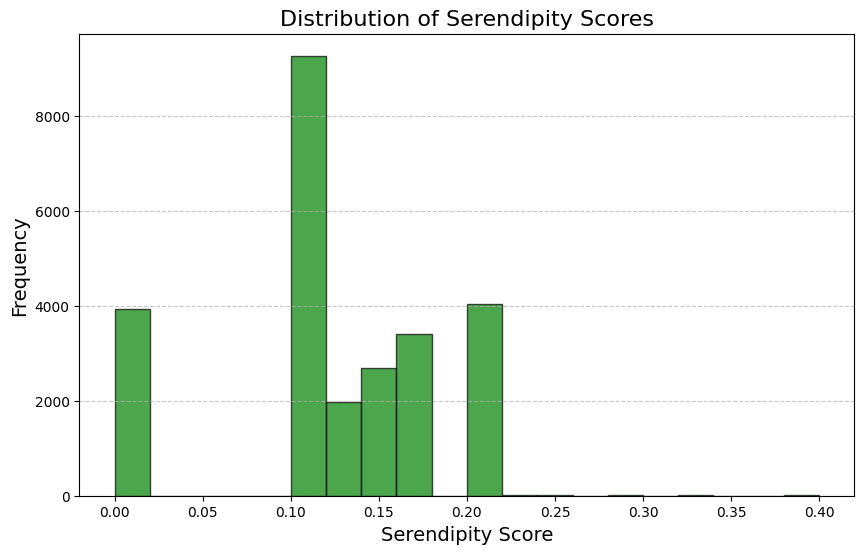

In [ ]:
def plot_serendipity_histogram(serendipities):
    plt.figure(figsize=(10, 6))
    plt.hist(serendipities, bins=20, color='green', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Serendipity Scores', fontsize=16)
    plt.xlabel('Serendipity Score', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage
plot_serendipity_histogram(serendipities)


## Novelty

In [ ]:
# Total number of articles in the training set
total_count = sum(article_counts.values())

# Create article_popularity dictionary
article_popularity = {article: count / total_count for article, count in article_counts.items()}

In [ ]:
def calculate_novelty(recommendations, article_popularity):
    """
    Calculate the Novelty Score for recommendations.

    Args:
        recommendations (list of list): Lists of recommended article IDs for each user.
        article_popularity (dict): Dictionary mapping article IDs to popularity probabilities.

    Returns:
        float: Average Novelty Score across all users.
    """
    novelty_scores = []
    for rec_list in recommendations:
        novelty_sum = 0
        for article in rec_list:
            # Get the popularity of the article, default to a very small probability
            prob = article_popularity.get(article, 1e-6)
            novelty_sum += -np.log(prob)

        # Average novelty score for the user's recommendation list
        novelty_scores.append(novelty_sum / len(rec_list) if len(rec_list) > 0 else 0)

    return novelty_scores
novelty_scores = calculate_novelty(article_id_recommendations, article_popularity)
novelty_score = np.mean(novelty_scores)
print(f"Novelty Score: {novelty_score:.4f}")

Novelty Score: 13.4958


Novelty measures how "new" or "unfamiliar" the recommended items are to the user, often based on their global popularity:

Highly popular items are considered less novel because they are likely to be known by most users.
Less popular items are considered more novel because they have a higher likelihood of being new to the user.

A Novelty Score of 13.8155 indicates that the recommended articles are highly novel, meaning the system suggests articles that are generally less popular and not commonly seen by users.

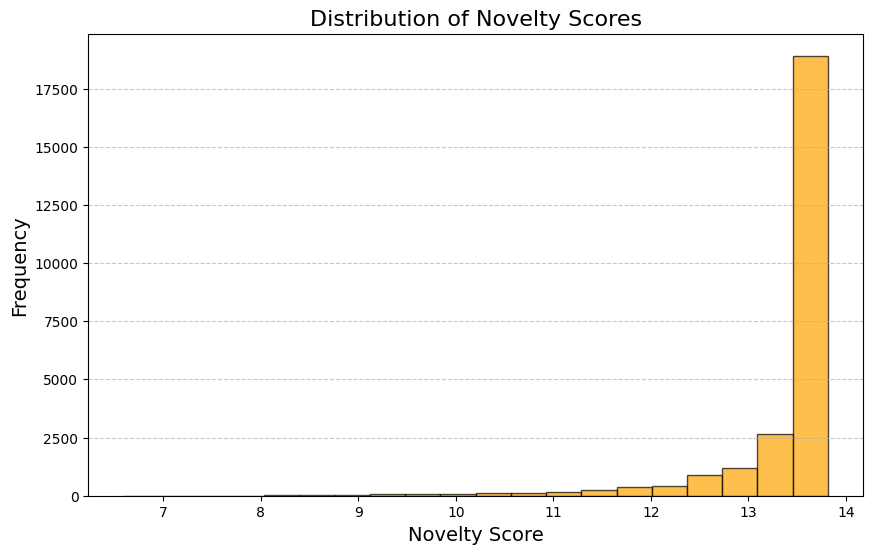

In [ ]:
def plot_novelty_histogram(novelty_scores):
    plt.figure(figsize=(10, 6))
    plt.hist(novelty_scores, bins=20, color='orange', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Novelty Scores', fontsize=16)
    plt.xlabel('Novelty Score', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage
plot_novelty_histogram(novelty_scores)

In [ ]:
total_articles = embedding_matrix.shape[0]


In [ ]:
def calculate_item_coverage(recommendations, total_articles):
    """
    Calculate the Item Coverage for recommendations.

    Args:
        recommendations (list of list): Lists of recommended article IDs for each user.
        total_articles (int): Total number of articles available in the catalog.

    Returns:
        float: Coverage Score as a fraction of total articles covered.
    """
    # Unique articles recommended across all users
    recommended_articles = set(article for rec_list in recommendations for article in rec_list)

    # Coverage is the fraction of unique articles recommended
    return recommended_articles, len(recommended_articles) / total_articles
recommended_articles,_ = calculate_item_coverage(article_id_recommendations, total_count)
_,coverage_score = calculate_item_coverage(article_id_recommendations, total_count)
print(f"Item Coverage Score: {coverage_score:.4f}")

Item Coverage Score: 0.1044


Coverage evaluates how well the recommendation system utilizes the available content:

High Coverage: Suggests that the system explores a wide variety of articles.
Low Coverage: Indicates that the system focuses only on a limited set of articles, potentially overlooking many others.

An Item Coverage Score of 0.0316 means that the recommendation system uses only about 3.16% of the total articles in the catalog across all its recommendations.
This indicates a strong bias toward a small subset of articles, likely the most relevant or popular ones.

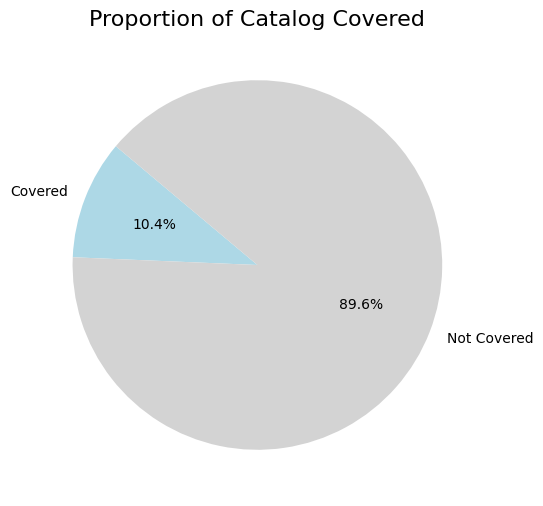

In [ ]:
def plot_coverage_pie(recommended_articles, total_articles):
    coverage_score = len(recommended_articles) / total_articles
    plt.figure(figsize=(8, 6))
    plt.pie(
        [coverage_score, 1 - coverage_score],
        labels=["Covered", "Not Covered"],
        autopct="%1.1f%%",
        colors=["lightblue", "lightgrey"],
        startangle=140
    )
    plt.title("Proportion of Catalog Covered", fontsize=16)
    plt.show()

# Example usage
plot_coverage_pie(recommended_articles, total_count)